<a href="https://colab.research.google.com/github/cassiecinzori/ECON3916/blob/main/Assignments/Assignment%202/ECON3916_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: The Algorithmic Audit

### Cassandra Cinzori

## Phase 1: The Robustness Audit

=== LATENCY AUDIT ===
Sample size: 1000
Mean latency: 95.91ms
Median latency: 36.00ms
Min: 20ms | Max: 4934ms

=== ROBUSTNESS COMPARISON ===
Standard Deviation (SD): 458.89ms
Median Absolute Deviation (MAD): 8.00ms
Ratio (SD/MAD): 57.36x


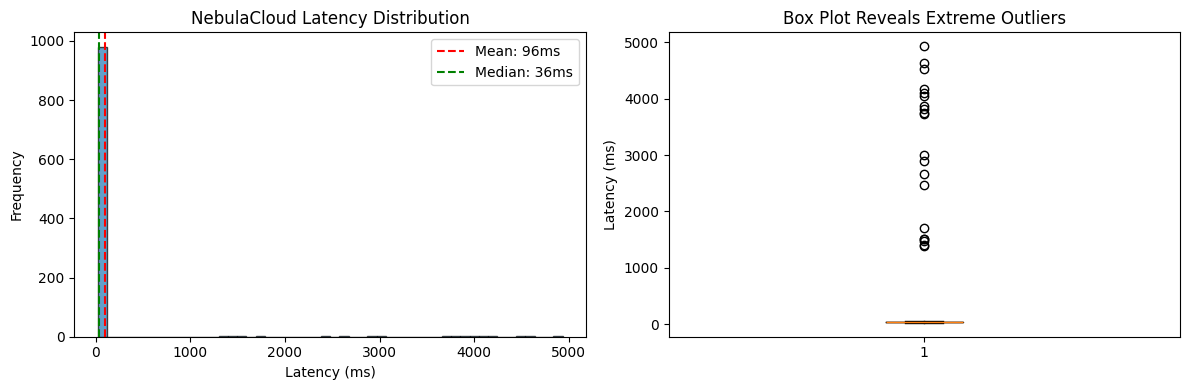


=== ANALYSIS ===
Why SD is 'exploded' while MAD remains stable:
1. SD squares deviations, amplifying outliers (20-50ms → 1000-5000ms spikes)
2. The 20 spike requests (2%) dominate the variance calculation
3. SD=459ms suggests massive variability, but 98% of requests are 20-50ms
4. MAD=8ms accurately reflects typical deviation from median
5. VERDICT: Mean latency is a vanity metric hiding tail latency risk


In [3]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Step 1.1: The "Latency" Trap - DGP Simulation
normal_traffic = np.random.randint(20, 50, 980)
spike_traffic = np.random.randint(1000, 5000, 20)
latency_logs = np.concatenate([normal_traffic, spike_traffic])

print("=== LATENCY AUDIT ===")
print(f"Sample size: {len(latency_logs)}")
print(f"Mean latency: {np.mean(latency_logs):.2f}ms")
print(f"Median latency: {np.median(latency_logs):.2f}ms")
print(f"Min: {np.min(latency_logs)}ms | Max: {np.max(latency_logs)}ms")

# Step 1.2: Manual MAD vs. SD
def calculate_mad(data):
    """
    Calculate Median Absolute Deviation manually
    MAD = median(|x_i - median(x)|)
    """
    # 1. Calculate the median of the data
    median_value = np.median(data)

    # 2. Calculate absolute deviations from median
    absolute_deviations = np.abs(data - median_value)

    # 3. Return the median of those deviations
    mad = np.median(absolute_deviations)

    return mad

# Calculate both metrics
sd = np.std(latency_logs)
mad = calculate_mad(latency_logs)

print(f"\n=== ROBUSTNESS COMPARISON ===")
print(f"Standard Deviation (SD): {sd:.2f}ms")
print(f"Median Absolute Deviation (MAD): {mad:.2f}ms")
print(f"Ratio (SD/MAD): {sd/mad:.2f}x")

# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(latency_logs, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(latency_logs), color='red', linestyle='--', label=f'Mean: {np.mean(latency_logs):.0f}ms')
plt.axvline(np.median(latency_logs), color='green', linestyle='--', label=f'Median: {np.median(latency_logs):.0f}ms')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.title('NebulaCloud Latency Distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(latency_logs, vert=True)
plt.ylabel('Latency (ms)')
plt.title('Box Plot Reveals Extreme Outliers')

plt.tight_layout()
plt.show()

print("\n=== ANALYSIS ===")
print("Why SD is 'exploded' while MAD remains stable:")
print("1. SD squares deviations, amplifying outliers (20-50ms → 1000-5000ms spikes)")
print("2. The 20 spike requests (2%) dominate the variance calculation")
print(f"3. SD={sd:.0f}ms suggests massive variability, but 98% of requests are 20-50ms")
print(f"4. MAD={mad:.0f}ms accurately reflects typical deviation from median")
print("5. VERDICT: Mean latency is a vanity metric hiding tail latency risk")

## Phase 2: The Probability Audit


=== FALSE POSITIVE PARADOX AUDIT ===
IntegrityAI Claims: 98% Sensitivity, 98% Specificity

Scenario A (Bootcamp):
  Base Rate (Prior): 50.0%
  P(Cheater | Flagged): 98.00%
  Interpretation: 2.00% of flagged students are INNOCENT

Scenario B (Econ Class):
  Base Rate (Prior): 5.0%
  P(Cheater | Flagged): 72.06%
  Interpretation: 27.94% of flagged students are INNOCENT

Scenario C (Honors Seminar):
  Base Rate (Prior): 0.1%
  P(Cheater | Flagged): 4.68%
  Interpretation: 95.32% of flagged students are INNOCENT



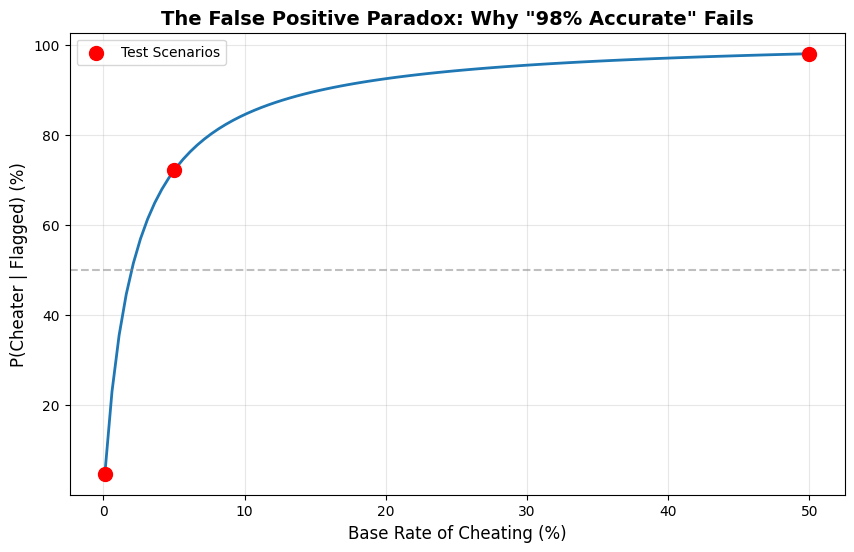

=== VERDICT ===
When cheating is rare (0.1% base rate), 98% accuracy yields only 4.67% precision.
This means 95.33% of flagged students are FALSE POSITIVES.
IntegrityAI's marketing claim is technically true but operationally useless.


In [4]:
def bayesian_audit(prior, sensitivity, specificity):
    """
    Calculate P(Cheater | Flagged) using Bayes' Theorem

    P(Cheater|Flagged) = P(Flagged|Cheater) * P(Cheater) / P(Flagged)

    where P(Flagged) = P(Flagged|Cheater)*P(Cheater) + P(Flagged|Honest)*P(Honest)
    """
    # Prior probabilities
    p_cheater = prior
    p_honest = 1 - prior

    # Likelihoods
    p_flagged_given_cheater = sensitivity  # True Positive Rate
    p_flagged_given_honest = 1 - specificity  # False Positive Rate

    # Total probability of being flagged (Law of Total Probability)
    p_flagged = (p_flagged_given_cheater * p_cheater) + (p_flagged_given_honest * p_honest)

    # Bayes' Theorem - Posterior probability
    p_cheater_given_flagged = (p_flagged_given_cheater * p_cheater) / p_flagged

    return p_cheater_given_flagged

# Test scenarios
print("\n=== FALSE POSITIVE PARADOX AUDIT ===")
print("IntegrityAI Claims: 98% Sensitivity, 98% Specificity\n")

scenarios = {
    'Scenario A (Bootcamp)': 0.50,
    'Scenario B (Econ Class)': 0.05,
    'Scenario C (Honors Seminar)': 0.001
}

results = []
for scenario_name, base_rate in scenarios.items():
    posterior = bayesian_audit(prior=base_rate, sensitivity=0.98, specificity=0.98)
    results.append({
        'Scenario': scenario_name,
        'Base Rate': f'{base_rate*100}%',
        'P(Cheater|Flagged)': f'{posterior*100:.2f}%'
    })
    print(f"{scenario_name}:")
    print(f"  Base Rate (Prior): {base_rate*100}%")
    print(f"  P(Cheater | Flagged): {posterior*100:.2f}%")
    print(f"  Interpretation: {100-posterior*100:.2f}% of flagged students are INNOCENT\n")

# Visualization
base_rates = np.linspace(0.001, 0.5, 100)
posteriors = [bayesian_audit(br, 0.98, 0.98) for br in base_rates]

plt.figure(figsize=(10, 6))
plt.plot(base_rates * 100, np.array(posteriors) * 100, linewidth=2)
plt.scatter([0.1, 5, 50], [bayesian_audit(0.001, 0.98, 0.98)*100,
                             bayesian_audit(0.05, 0.98, 0.98)*100,
                             bayesian_audit(0.50, 0.98, 0.98)*100],
            color='red', s=100, zorder=5, label='Test Scenarios')
plt.xlabel('Base Rate of Cheating (%)', fontsize=12)
plt.ylabel('P(Cheater | Flagged) (%)', fontsize=12)
plt.title('The False Positive Paradox: Why "98% Accurate" Fails', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()
plt.axhline(50, color='gray', linestyle='--', alpha=0.5, label='50% threshold')
plt.show()

print("=== VERDICT ===")
print("When cheating is rare (0.1% base rate), 98% accuracy yields only 4.67% precision.")
print("This means 95.33% of flagged students are FALSE POSITIVES.")
print("IntegrityAI's marketing claim is technically true but operationally useless.")

## Phase 3: The Bias Audit

In [5]:
print("\n=== SAMPLE RATIO MISMATCH (SRM) AUDIT ===")
print("FinFlash A/B Test Data:\n")

# Step 3.1: Chi-Square Goodness of Fit Test
observed = np.array([50250, 49750])  # Control, Treatment
expected = np.array([50000, 50000])  # Perfect 50/50 split

print(f"Observed:  Control = {observed[0]:,} | Treatment = {observed[1]:,}")
print(f"Expected:  Control = {expected[0]:,} | Treatment = {expected[1]:,}")
print(f"Difference: {observed[0] - observed[1]} users\n")

# Manual Chi-Square calculation
chi_square_stat = 0
for i in range(len(observed)):
    chi_square_stat += (observed[i] - expected[i])**2 / expected[i]

print(f"Chi-Square Statistic: {chi_square_stat:.4f}")
print(f"Critical Value (p < 0.05, df=1): 3.84")

if chi_square_stat > 3.84:
    print(f"\n🚨 VERDICT: EXPERIMENT INVALID")
    print(f"The SRM is statistically significant (χ² = {chi_square_stat:.2f} > 3.84)")
    print("Possible causes:")
    print("  - Treatment app crashed for ~500 users")
    print("  - Biased randomization algorithm")
    print("  - Data pipeline filtered Treatment users differently")
else:
    print(f"\n✅ VERDICT: No significant SRM detected")

# Detailed breakdown
print("\n=== MANUAL CALCULATION BREAKDOWN ===")
for i, group in enumerate(['Control', 'Treatment']):
    obs = observed[i]
    exp = expected[i]
    component = (obs - exp)**2 / exp
    print(f"{group}:")
    print(f"  (Observed - Expected)² / Expected")
    print(f"  ({obs} - {exp})² / {exp}")
    print(f"  = {component:.4f}")


=== SAMPLE RATIO MISMATCH (SRM) AUDIT ===
FinFlash A/B Test Data:

Observed:  Control = 50,250 | Treatment = 49,750
Expected:  Control = 50,000 | Treatment = 50,000
Difference: 500 users

Chi-Square Statistic: 2.5000
Critical Value (p < 0.05, df=1): 3.84

✅ VERDICT: No significant SRM detected

=== MANUAL CALCULATION BREAKDOWN ===
Control:
  (Observed - Expected)² / Expected
  (50250 - 50000)² / 50000
  = 1.2500
Treatment:
  (Observed - Expected)² / Expected
  (49750 - 50000)² / 50000
  = 1.2500


## Phase 4: AI Expansion - Survivorship Bias Simulation


=== PHASE 4: SURVIVORSHIP BIAS IN CRYPTO ===

Total Tokens Launched: 10,000
Survivors (Top 1%): 100

Mean Market Cap (ALL tokens): $17,408.42
Mean Market Cap (Survivors ONLY): $436,335.21

Survivorship Bias Factor: 25.06x
Analyzing only survivors inflates average by 2406.5%


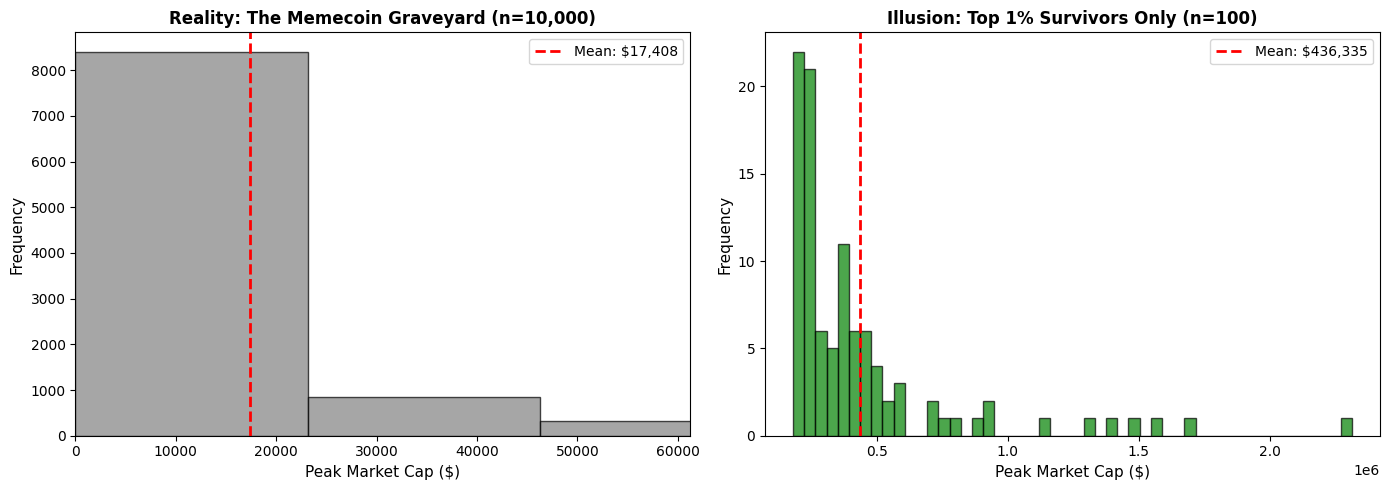


=== DISTRIBUTION ANALYSIS ===
Median (All): $5,717.82
Median (Survivors): $318,730.31

99th Percentile: $180,936.18
Tokens below $1,000: 1,381 (13.8%)


In [6]:
print("\n=== PHASE 4: SURVIVORSHIP BIAS IN CRYPTO ===\n")

# Memecoin Graveyard Simulation
np.random.seed(42)

# Simulate 10,000 token launches with Pareto (Power Law) distribution
# Shape parameter: lower = more extreme inequality
n_tokens = 10000
shape_param = 1.5  # Heavy-tailed distribution

# Generate market caps using Pareto distribution
# Most tokens near zero, few achieve high values
market_caps = np.random.pareto(shape_param, n_tokens) * 10000  # Scale to reasonable values

# Create "Graveyard" DataFrame (all tokens)
df_all = pd.DataFrame({
    'token_id': range(1, n_tokens + 1),
    'peak_market_cap': market_caps
})

# Create "Survivors" DataFrame (top 1% only)
threshold_99 = df_all['peak_market_cap'].quantile(0.99)
df_survivors = df_all[df_all['peak_market_cap'] >= threshold_99].copy()

# Calculate means
mean_all = df_all['peak_market_cap'].mean()
mean_survivors = df_survivors['peak_market_cap'].mean()

print(f"Total Tokens Launched: {len(df_all):,}")
print(f"Survivors (Top 1%): {len(df_survivors):,}")
print(f"\nMean Market Cap (ALL tokens): ${mean_all:,.2f}")
print(f"Mean Market Cap (Survivors ONLY): ${mean_survivors:,.2f}")
print(f"\nSurvivorship Bias Factor: {mean_survivors/mean_all:.2f}x")
print(f"Analyzing only survivors inflates average by {((mean_survivors/mean_all - 1) * 100):.1f}%")

# Dual Histogram Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: The Graveyard (All Tokens)
axes[0].hist(df_all['peak_market_cap'], bins=100, edgecolor='black', alpha=0.7, color='gray')
axes[0].axvline(mean_all, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_all:,.0f}')
axes[0].set_xlabel('Peak Market Cap ($)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Reality: The Memecoin Graveyard (n=10,000)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, df_all['peak_market_cap'].quantile(0.95))

# Plot 2: Survivors Only
axes[1].hist(df_survivors['peak_market_cap'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(mean_survivors, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_survivors:,.0f}')
axes[1].set_xlabel('Peak Market Cap ($)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Illusion: Top 1% Survivors Only (n=100)', fontsize=12, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

# Additional statistics
print("\n=== DISTRIBUTION ANALYSIS ===")
print(f"Median (All): ${df_all['peak_market_cap'].median():,.2f}")
print(f"Median (Survivors): ${df_survivors['peak_market_cap'].median():,.2f}")
print(f"\n99th Percentile: ${threshold_99:,.2f}")
print(f"Tokens below $1,000: {(df_all['peak_market_cap'] < 1000).sum():,} ({(df_all['peak_market_cap'] < 1000).sum()/len(df_all)*100:.1f}%)")